# Wine reviews


### Authors

- Krzysztof Juszczyk
- Mateusz Serzysko
- Maksymilian Czudziak

## Preparation

### Download

In [ ]:
from google.colab import files

! pip install -q kaggle
! pip install lazypredict
! pip install xgboost
! pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadarai5","key":"ae9c6d21c80417abdbeb2b4e0cf570f8"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download zynicide/wine-reviews

 77% 39.0M/50.9M [00:00<00:00, 184MB/s] 
100% 50.9M/50.9M [00:00<00:00, 184MB/s]


In [ ]:
! unzip -n wine-reviews.zip

Archive:  wine-reviews.zip
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
import nltk
import xgboost
from tqdm import tqdm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Helper functions

In [ ]:
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [ ]:
# Function that prepares the text part of data
def prepare_text_data(df):

    stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    keywords = []
    for sent in df['description']:
        kw = [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(sent.lower())) if pos == 'JJ']

        keywords.append([*set(kw)])
        # sent = keywords
        # foo = pd.get_dummies(keywords)

    # print(df)
    all_keywords = pd.DataFrame(flatten_list(keywords))


    new_data = pd.DataFrame(df, copy=True)
    new_data['keywords'] = keywords
    return new_data


In [ ]:
def prepare_dataset(df, X_columns, y_column, nan_column=False):
    def onehot_when_needed(df):
        result = []
        for column in df.columns:
            current_column = df[column]
            if not pd.api.types.is_numeric_dtype(df[column]):
                current_column = pd.get_dummies(df[column], prefix=column, dummy_na=nan_column)
            result.append(current_column)
        return pd.concat(result, axis=1)

    def get_duplicate_columns(df):
        duplicateColumnNames = set()
        for x in range(df.shape[1]):
            col = df.iloc[:, x]
            for y in range(x + 1, df.shape[1]):
                otherCol = df.iloc[:, y]
                if col.equals(otherCol):
                    duplicateColumnNames.add(df.columns.values[y])
        return list(duplicateColumnNames)

    X = onehot_when_needed(df[X_columns])
    y = np.asarray(df[y_column]).reshape(-1, 1)
    return X, y

### Load, prepare and split dataset

In [ ]:
# load file with index row
df = pd.read_csv('winemag-data-130k-v2.csv', sep=',', index_col=0)

In [ ]:
# Get only first 10000
# df = df.loc[:50000, :]

In [ ]:
# Drop NaNs
df = df.dropna()
# Maybe only for points?
# df = df[df['points'].notna()]

In [ ]:
X, y = prepare_dataset(df, ['country', 'province', 'variety', 'price'], 'points')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [ ]:
print(X_train.head())

       country_US  province_California  province_New York  province_Oregon  \
47681           1                    0                  0                0   
53779           1                    1                  0                0   
38654           1                    1                  0                0   
10575           1                    1                  0                0   
56672           1                    1                  0                0   

       province_Washington  variety_Abouriou  variety_Aglianico  \
47681                    1                 0                  0   
53779                    0                 0                  0   
38654                    0                 0                  0   
10575                    0                 0                  0   
56672                    0                 0                  0   

       variety_Albariño  variety_Alicante Bouschet  variety_Aligoté  ...  \
47681                 0                          0  

### Data research

In [ ]:
# Get types of all columns
df.dtypes
# We have objects, because of NaNs

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

Text(0, 0.5, 'price (USD)')

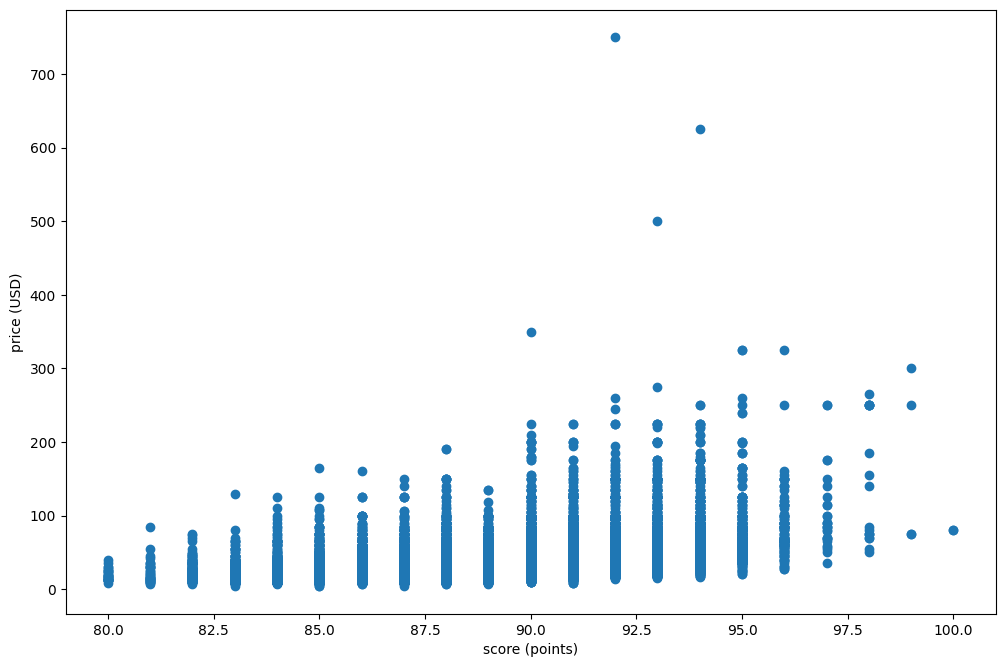

In [ ]:
# Relation between points and price
df = df.loc[df['price'] < 1000]
plt.scatter(x=df['points'], y=df['price'])
plt.xlabel('score (points)')
plt.ylabel('price (USD)')

## K neares neighbours

In [ ]:
def knn_predict_points(k, X_train, y_train, X_test, y_test):
    KNNmodel = KNeighborsClassifier(n_neighbors=k)
    KNNmodel.fit(X_train, y_train)
    y_train_preds = KNNmodel.predict(X_train)

    y_test_preds = KNNmodel.predict(X_test)

    return y_train_preds, y_test_preds

In [ ]:
y_train_preds, y_test_preds = knn_predict_points(10, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# Train accuracy
(y_train.flatten() == y_train_preds).mean() * 100

29.849690539345712

In [ ]:
# Test accuracy
(y_test.flatten() == y_test_preds).mean() * 100

14.680545585068197

In [ ]:
def search_best_k(ks, X_train, y_train, X_test, y_test):
    best_trn = 0
    best_tst = 0
    accs=[]

    for i in tqdm(ks, position=0, leave=True):
        y_train_preds, y_test_preds = knn_predict_points(i, X_train, y_train, X_test, y_test)
        trn_acc = (y_train.flatten() == y_train_preds).mean() * 100
        tst_acc = (y_test.flatten() == y_test_preds).mean() * 100

        accs.append(trn_acc)
        accs.append(tst_acc)
        if trn_acc > best_trn:
            best_trn=trn_acc
        if tst_acc > best_tst:
            best_tst = tst_acc
    return ks, accs, best_trn, best_tst

In [ ]:
ks, accs, best_trn, best_tst = search_best_k(range(2, 20), X_train, y_train, X_test, y_test)

100%|██████████| 18/18 [00:26<00:00,  1.48s/it]


In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

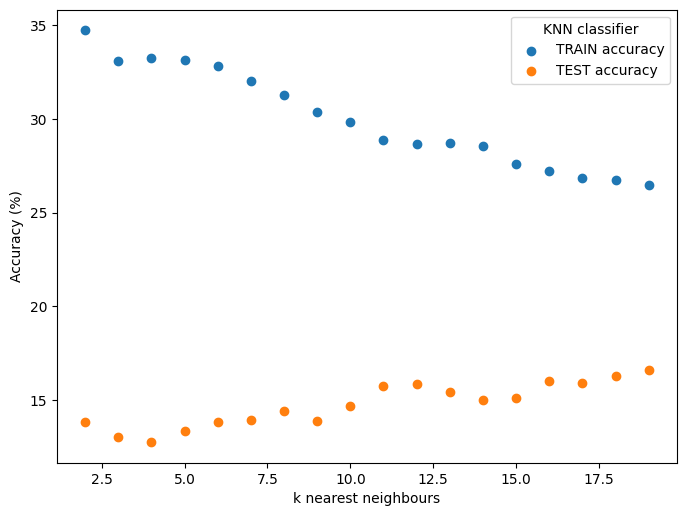

Best train accuracy: 34.730327144120245
Best test accuracy: 16.582914572864322


In [ ]:
plt.scatter(x=ks, y=accs[::2], label='TRAIN accuracy')
plt.scatter(x=ks, y=accs[1::2], label='TEST accuracy')
plt.legend(title='KNN classifier')
plt.xlabel('k nearest neighbours')
plt.ylabel('Accuracy (%)')
plt.show()

print(f'Best train accuracy: {best_trn}')
print(f'Best test accuracy: {best_tst}')

## K-means

In [ ]:
def kmeans_predict_points(X_train, y_train, X_test, y_test):
    # kmeans = KMeans(n_clusters=20, random_state=0) # 20 is amount of classes = amount of avaliable points (80-100)
    kmeans = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=20, random_state=None, tol=0.0001, verbose=0)

    # print(kmeans.cluster_centers_)
    # print('labels', kmeans.labels_)
    y_train_preds = kmeans.fit_predict(X_train)
    y_test_preds = kmeans.fit_predict(X_test)
    # foo = list(zip(y_train, y_train_preds))

    return y_train_preds, y_test_preds

In [ ]:
y_train_preds, y_test_preds = kmeans_predict_points(X_train, y_train, X_test, y_test)

In [ ]:
# Train accuracy
(y_train.flatten() == y_train_preds).mean() * 100

0.0

In [ ]:
# Test accuracy
(y_test.flatten() == y_test_preds).mean() * 100

0.0

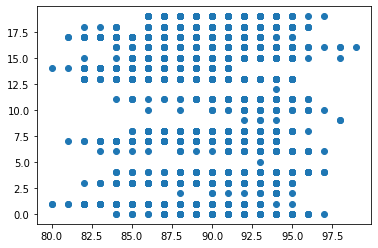

In [ ]:
plt.scatter(x=y_train, y=y_train_preds)

## Lazy predict

In [ ]:
from lazypredict.Supervised import LazyClassifier

In [ ]:
def lazy_predict_points(X_train, y_train, X_test, y_test):
    clf = LazyClassifier(verbose=0, custom_metric=None)
    models = clf.fit(X_train, X_test, y_train, y_test)
    return models

In [ ]:
# lazy_predict_points(X_train, y_train, X_test, y_test)

## Logistic Regression

In [ ]:
def launch_lr(X_train, y_train, X_test, y_test):
    LRmodel = LogisticRegression()
    LRmodel.fit(X_train, y_train)
    y_train_preds = LRmodel.predict(X_train)
    y_test_preds = LRmodel.predict(X_test)
    return y_train_preds, y_test_preds

In [ ]:
y_train_preds, y_test_preds = launch_lr(X_train, y_train, X_test, y_test)

In [ ]:
# Train accuracy
(y_train_preds == y_train).mean()  * 100

12.306575950955352

In [ ]:
# Test accuracy
(y_test_preds == y_test).mean() * 100

12.35306880005607

## XGBoost

In [ ]:
def launch_xgb_classifier(X_train, X_test, y_train, y_test, estimators=200, depth=6):
    XGBmodel = xgboost.XGBClassifier(n_estimators=estimators, max_depth=depth)
    XGBmodel.fit(X_train, y_train)

    y_train_preds = XGBmodel.predict(X_train)
    y_test_preds = XGBmodel.predict(X_test)

    return y_train_preds, y_test_preds

In [ ]:
def launch_xgb_regressor(X_train, X_test, y_train, y_test, estimators=200, depth=6):
    XGBmodel = xgboost.XGBRegressor(n_estimators=estimators, max_depth=depth)
    XGBmodel.fit(X_train, y_train)

    y_train_preds = XGBmodel.predict(X_train)
    y_test_preds = XGBmodel.predict(X_test)

    return y_train_preds, y_test_preds

In [ ]:
def print_accuracy(set_type_name, y_preds, y_true):
  print(f'{set_type_name} accuracy: {(y_preds == y_true).mean() * 100}')

In [ ]:
def print_accuracy_eps(set_type_name, y_preds, y_true, eps):
    print(f'{set_type_name} accuracy with eps {eps} : {np.mean(abs(y_preds - y_true) < eps) * 100}')

In [ ]:
def adjectives_stats_sorted(df):
    adjectives = {}
    for sent in tqdm(df['description']):
        kw = [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(sent.lower())) if pos == 'JJ']

        for word in kw:
            if word in adjectives:
                adjectives[word] += 1
            else:
                adjectives[word] = 1
    return sorted(adjectives.items(), key=lambda x:-x[1])


In [ ]:
def keywords_for_reviews(df):
    stop = set(nltk.corpus.stopwords.words('english') + list(string.punctuation))
    keywords = []
    for sent in df['description']:
        kw = [word for (word, pos) in nltk.pos_tag(nltk.word_tokenize(sent.lower())) if pos in ['JJ', 'JJR', 'JJS']]

        keywords.append([*set(kw)])
    return keywords

In [ ]:
keywords_lists = keywords_for_reviews(df)

In [ ]:
def prepare_text_data_for_first_n(df, how_many, keywords_in_review):
    all_keywords = pd.DataFrame(flatten_list(keywords_in_review))
    counted_keywords = all_keywords.value_counts()
    sorted_keywords = [keyword[0] for keyword in counted_keywords.index.values]
    best_n_keywords = sorted_keywords[:how_many]

    new_df = pd.DataFrame.copy(df)
    for keyword in best_n_keywords:
        new_df[f'classed_{keyword}'] = pd.Series(keywords_in_review).apply(lambda row: int(keyword in row))

    return new_df

In [ ]:
def many_word_exp_print(keywords_in_review, y, up_limit, test_size):
  max_eps = 5
  for how_many_words in range(100, up_limit, 100):
      X = prepare_text_data_for_first_n(pd.DataFrame(), how_many_words, keywords_in_review)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

      y_train_preds, y_test_preds = launch_xgb_regressor(X_train, X_test, y_train, y_test)

      print(f'Dla {how_many_words} słów i zbioru testowego wielkości {test_size}:')
      for eps in np.arange(0.5, max_eps + 5, 0.5):
          print_accuracy_eps('Train', y_train_preds, y_train, eps)
          print_accuracy_eps('Test', y_test_preds, y_test, eps)
      print('\n')

In [ ]:
y = df['points']
many_word_exp_print(keywords_lists, y, 600, 0.33)

[17:16:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Dla 100 słów i zbioru testowego wielkości 0.33:
Train accuracy with eps 0.5 : 19.363395225464192
Test accuracy with eps 0.5 : 15.506101938262743
Train accuracy with eps 1.0 : 37.54199823165341
Test accuracy with eps 1.0 : 30.832735104091892
Train accuracy with eps 1.5 : 53.77541998231653
Test accuracy with eps 1.5 : 45.58506819813353
Train accuracy with eps 2.0 : 66.94960212201592
Test accuracy with eps 2.0 : 58.11198851399857
Train accuracy with eps 2.5 : 77.0999115826702
Test accuracy with eps 2.5 : 68.55707106963388
Train accuracy with eps 3.0 : 85.02210433244916
Test accuracy with eps 3.0 : 77.45872218234028
Train accuracy with eps 3.5 : 90.04420866489832
Test accuracy with eps 3.5 : 83.41708542713567
Train accuracy with eps 4.0 : 93.98762157382848
Test accuracy with eps 4.0 : 88.2986360373295
Train accuracy with eps 4.5 : 96.07427055702917
Test accuracy wi

In [ ]:
df_200 = prepare_text_data_for_first_n(df, 200, keywords_lists)
X_train, y_train, X_test, y_test = prepare_dataset(df_200)

TypeError: ignored

In [ ]:
print(X_train.shape, y_train.shape)
# print(X_train, y_train)

In [ ]:
XGBmodel = xgboost.XGBClassifier(n_estimators=300, max_depth=3)
X_train, y_train, X_test, y_test = prepare_dataset(df_200.head(12000))
XGBmodel.fit(X_train, y_train)

In [ ]:
y_train_preds = XGBmodel.predict(X_train)
y_test_preds = XGBmodel.predict(X_test)

In [ ]:
# Accuracy for train
(y_train_preds == y_train).mean() * 100

In [ ]:
# Accuracy for test
(y_test_preds == y_test).mean() * 100

In [ ]:
y_train_preds = XGBmodel.predict(X_train)
y_test_preds = XGBmodel.predict(X_test)

In [ ]:
f'Accuracy for train: {(y_train_preds == y_train).mean() * 100}'

In [ ]:
f'Accuracy for test: {(y_test_preds == y_test).mean() * 100}'

In [ ]:
from types import prepare_class
df_for_tests = pd.DataFrame.copy(df)
df_for_tests = prepare_class(df_for_tests)
df_for_tests = prepare_text_data_for_first_n(df_for_tests, 200, keywords_for_reviews)

print(df_for_tests.shape)
print(df_for_tests)

# Te

In [ ]:
df_geo = pd.read_csv('winemag-data-130k-v2-geo.csv', sep=',', index_col=0).drop(columns=['latitude', 'longitude'])

In [ ]:
df_geo.head()

In [ ]:
df_geo = df_geo[:10000]